## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [8]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1_L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_l2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [14]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_l2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1_l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 13s 267us/step - loss: 2.4614 - accuracy: 0.0984 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 13s 258us/step - loss: 2.4614 - accuracy: 0.0975 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 12s 248us/step - loss: 2.4614 - accuracy: 0.0969 - val_loss: 2.4613 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
______________________________________________

50000/50000 [==============================] - 13s 263us/step - loss: 1.7668 - accuracy: 0.4780 - val_loss: 1.7826 - val_accuracy: 0.4726
Epoch 46/50
50000/50000 [==============================] - 13s 262us/step - loss: 1.7636 - accuracy: 0.4779 - val_loss: 1.7841 - val_accuracy: 0.4725
Epoch 47/50
50000/50000 [==============================] - 13s 257us/step - loss: 1.7599 - accuracy: 0.4780 - val_loss: 1.7982 - val_accuracy: 0.4652
Epoch 48/50
50000/50000 [==============================] - 13s 254us/step - loss: 1.7560 - accuracy: 0.4795 - val_loss: 1.7929 - val_accuracy: 0.4697
Epoch 49/50
50000/50000 [==============================] - 13s 259us/step - loss: 1.7531 - accuracy: 0.4804 - val_loss: 1.7829 - val_accuracy: 0.4701
Epoch 50/50
50000/50000 [==============================] - 13s 264us/step - loss: 1.7492 - accuracy: 0.4825 - val_loss: 1.7819 - val_accuracy: 0.4670
Experiment with Regulizer = 0.000000
Model: "model_1"
__________________________________________________________

Epoch 42/50
50000/50000 [==============================] - 15s 299us/step - loss: 1.6485 - accuracy: 0.5120 - val_loss: 1.7045 - val_accuracy: 0.4923
Epoch 43/50
50000/50000 [==============================] - 15s 293us/step - loss: 1.6400 - accuracy: 0.5162 - val_loss: 1.7217 - val_accuracy: 0.4824
Epoch 44/50
50000/50000 [==============================] - 15s 290us/step - loss: 1.6354 - accuracy: 0.5154 - val_loss: 1.6846 - val_accuracy: 0.5018
Epoch 45/50
50000/50000 [==============================] - 15s 302us/step - loss: 1.6289 - accuracy: 0.5185 - val_loss: 1.7634 - val_accuracy: 0.4644
Epoch 46/50
50000/50000 [==============================] - 15s 293us/step - loss: 1.6255 - accuracy: 0.5198 - val_loss: 1.6915 - val_accuracy: 0.4999
Epoch 47/50
50000/50000 [==============================] - 15s 305us/step - loss: 1.6240 - accuracy: 0.5197 - val_loss: 1.7580 - val_accuracy: 0.4575
Epoch 48/50
50000/50000 [==============================] - 14s 287us/step - loss: 1.6176 - accuracy:

50000/50000 [==============================] - 15s 298us/step - loss: 1.6651 - accuracy: 0.5098 - val_loss: 1.7132 - val_accuracy: 0.4820
Epoch 40/50
50000/50000 [==============================] - 14s 286us/step - loss: 1.6595 - accuracy: 0.5091 - val_loss: 1.6982 - val_accuracy: 0.4926
Epoch 41/50
50000/50000 [==============================] - 15s 291us/step - loss: 1.6513 - accuracy: 0.5123 - val_loss: 1.7419 - val_accuracy: 0.4754
Epoch 42/50
50000/50000 [==============================] - 14s 290us/step - loss: 1.6462 - accuracy: 0.5132 - val_loss: 1.7057 - val_accuracy: 0.4949
Epoch 43/50
50000/50000 [==============================] - 14s 282us/step - loss: 1.6400 - accuracy: 0.5142 - val_loss: 1.6848 - val_accuracy: 0.4957
Epoch 44/50
50000/50000 [==============================] - 14s 287us/step - loss: 1.6327 - accuracy: 0.5187 - val_loss: 1.6795 - val_accuracy: 0.4949
Epoch 45/50
50000/50000 [==============================] - 15s 299us/step - loss: 1.6286 - accuracy: 0.5188 - va

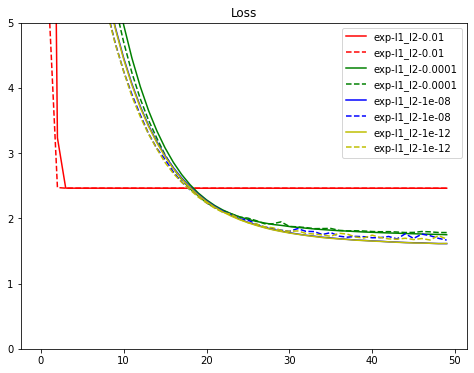

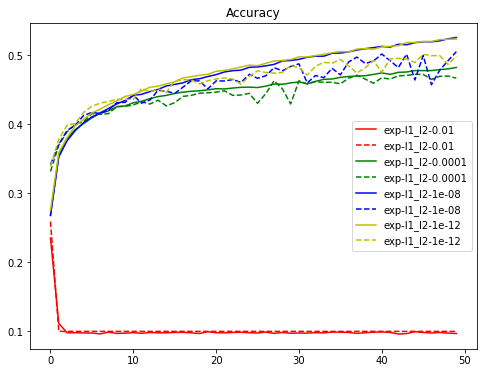

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()